In [2]:
import tifffile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
import SimpleITK as sitk
from scipy.ndimage import affine_transform
import scipy
import sys
sys.path.append(r'/home/apollo/Dev/UTvsXCT-preprocessing')
from preprocess_tools import register, aligner, signal

(500, 109, 65)


(500, 92, 37)

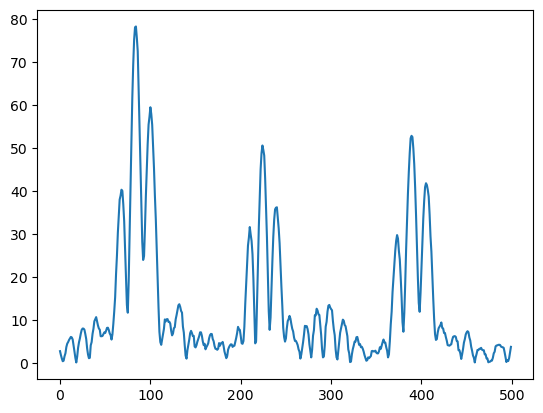

In [3]:
path = "/home/apollo/Dev/Data"
xct = tifffile.imread(os.path.join(path, "JI_7_aligned_90rotright_reslicetop.tif"))
ut_rf = tifffile.imread(os.path.join(path, "JI_7_rf.tiff"))
print(ut_rf.shape)
# Calculate envelope of UT
ut_env = signal.envelope(ut_rf)[:, 1:93, 13:50]

plt.plot(ut_env[:, 25, 10])
ut_env.shape

In [4]:
def rotate_volume_yx(
    vol, angle_y_deg=0.0, 
    angle_x_deg=0.0, order='Yx',
    voxel_size=(1.0, 1.0, 1.0),    # (dz, dy, dx)
    mode='fit',                    # 'preserve' or 'fit'
    cval=0.0, interp_order=1
):
    """
    Rotate 3D volume shaped (Z, Y, X) by angle_y about Y and angle_x about X
    in *physical space* (respecting voxel sizes), about the global center.

    order: 'Yx' = apply R_y then R_x ; 'Xy' = R_x then R_y
    mode : 'preserve' keeps original shape; 'fit' grows output to avoid loss
    """

    # Angles
    ay = np.deg2rad(angle_y_deg)
    ax = np.deg2rad(angle_x_deg)
    cy, sy = np.cos(ay), np.sin(ay)
    cx, sx = np.cos(ax), np.sin(ax)

    # Rotations in (Z, Y, X) coordinate order
    # About Y (rotate Z<->X)
    R_y = np.array([[ cy, 0.0,  sy],
                    [0.0, 1.0, 0.0],
                    [-sy, 0.0,  cy]], dtype=float)

    # About X (rotate Z<->Y)
    R_x = np.array([[ cx, -sx, 0.0],
                    [ sx,  cx, 0.0],
                    [0.0, 0.0, 1.0]], dtype=float)

    if order.lower() == 'yx':
        R = R_x @ R_y
    elif order.lower() == 'xy':
        R = R_y @ R_x
    else:
        raise ValueError("order must be 'Yx' or 'Xy'")

    # --- Physical-space handling ---
    dz, dy, dx = map(float, voxel_size)
    S  = np.diag([dz, dy, dx])          # index -> physical
    S_inv = np.diag([1.0/dz, 1.0/dy, 1.0/dx])  # physical -> index

    # The transform we need for affine_transform is OUTPUT->INPUT mapping in index space.
    # We want: x_in = S_inv @ R @ S @ (x_out - ctr_out) + ctr_in
    # => matrix M = S_inv @ R @ S ; offset chosen to rotate about center
    shp_in = np.array(vol.shape, dtype=float)
    ctr_in = (shp_in - 1.0) / 2.0

    # If preserving shape, output center = input center
    if mode == 'preserve':
        shp_out = shp_in.copy()
        ctr_out = ctr_in
    elif mode == 'fit':
        # Compute bounding box of rotated volume in index space:
        # 1) enumerate 8 corners in index coords centered at ctr_in
        zz = np.array([-(shp_in[0]-1)/2.0, (shp_in[0]-1)/2.0])
        yy = np.array([-(shp_in[1]-1)/2.0, (shp_in[1]-1)/2.0])
        xx = np.array([-(shp_in[2]-1)/2.0, (shp_in[2]-1)/2.0])
        corners = np.array(np.meshgrid(zz, yy, xx, indexing='ij')).reshape(3, -1)  # shape (3, 8)

        # 2) map corners: index -> physical, rotate, physical -> index
        M_phys = R
        corners_out = S_inv @ (M_phys @ (S @ corners))

        # 3) extents in index coords after rotation
        mins = corners_out.min(axis=1)
        maxs = corners_out.max(axis=1)

        # 4) full size to contain them (rounded up)
        shp_out = np.ceil(maxs - mins + 1.0).astype(int)

        # 5) choose output center at half (shp_out-1)
        ctr_out = (shp_out - 1.0) / 2.0
    else:
        raise ValueError("mode must be 'preserve' or 'fit'")

    # Combined OUTPUT->INPUT index transform
    M = S_inv @ R @ S

    # Offset so rotation is about the input center:
    # input_center = M @ output_center + offset  => offset = ctr_in - M @ ctr_out
    offset = ctr_in - M @ ctr_out

    # Run affine (single resample)
    out = affine_transform(
        vol, matrix=M, offset=offset,
        output_shape=tuple(shp_out.astype(int)),
        order=interp_order, mode='constant', cval=cval,
        prefilter=(interp_order > 1)
    )
    return out


In [5]:
# Import the register module to access YZ_XZ_inclination function

print("Calculating inclination angles for both UT and XCT volumes...")
print("="*60)

# Calculate angles for XCT volume
print("XCT Volume Analysis:")
print(f"XCT shape: {xct.shape}")
try:
    angle_yz_xct, angle_xz_xct = register.YZ_XZ_inclination(xct, volumeType='XCT', signal_percentage=1.0)
    print(f"  angle_yz (YZ plane tilt): {angle_yz_xct:.3f}°")
    print(f"  angle_xz (XZ plane tilt): {angle_xz_xct:.3f}°")
    print("  ✓ XCT angles calculated successfully")
except Exception as e:
    print(f"  ✗ Error calculating XCT angles: {e}")
    angle_yz_xct, angle_xz_xct = None, None

print()

# Calculate angles for UT envelope volume
print("UT Volume Analysis:")
print(f"UT envelope shape: {ut_env.shape}")
try:
    angle_yz_ut, angle_xz_ut = register.YZ_XZ_inclination(ut_env, volumeType='PAUT', signal_percentage=1.0, min_depth=80, max_depth=None)
    print(f"  angle_yz (YZ plane tilt): {angle_yz_ut:.3f}°")
    print(f"  angle_xz (XZ plane tilt): {angle_xz_ut:.3f}°")
    print("  ✓ UT angles calculated successfully")
except Exception as e:
    print(f"  ✗ Error calculating UT angles: {e}")
    angle_yz_ut, angle_xz_ut = None, None

print()
print("="*60)
print("SUMMARY:")
if angle_yz_xct is not None and angle_xz_xct is not None:
    print(f"XCT: YZ={angle_yz_xct:.2f}°, XZ={angle_xz_xct:.2f}°")
if angle_yz_ut is not None and angle_xz_ut is not None:
    print(f"UT:  YZ={angle_yz_ut:.2f}°, XZ={angle_xz_ut:.2f}°")


Calculating inclination angles for both UT and XCT volumes...
XCT Volume Analysis:
XCT shape: (197, 3282, 1618)


Finding surface points: 100%|██████████| 5029600/5029600 [00:40<00:00, 123381.08it/s]


  angle_yz (YZ plane tilt): -0.002°
  angle_xz (XZ plane tilt): 0.088°
  ✓ XCT angles calculated successfully

UT Volume Analysis:
UT envelope shape: (500, 92, 37)


Finding surface points: 100%|██████████| 37/37 [00:00<00:00, 2152.45it/s]

  angle_yz (YZ plane tilt): -1.584°
  angle_xz (XZ plane tilt): 15.640°
  ✓ UT angles calculated successfully

SUMMARY:
XCT: YZ=-0.00°, XZ=0.09°
UT:  YZ=-1.58°, XZ=15.64°


In [6]:
#Build aligned volumes using calculated angles

print("BUILDING ALIGNED VOLUMES:")
print("="*50)

# Apply rotations to XCT
print("Aligning XCT volume...")

xct_aligned = aligner.align_volume_xy(xct, volume_type='XCT')


# Apply rotations to UT
print("Aligning UT volume...")
ut_aligned = aligner.align_volume_xy(ut_env, volume_type='PAUT')
print("Aligning UT (3D) volume...")
ut_aligned_3d = rotate_volume_yx(ut_env, angle_y_deg=angle_yz_ut, angle_x_deg=angle_xz_ut, voxel_size=(0.016, 1, 1), mode="preserve")

print("="*50)

print("Original XCT shape:", xct.shape)
print("Aligned XCT shape:", xct_aligned.shape)
print("Original UT shape:", ut_env.shape)
print("Aligned UT shape:", ut_aligned.shape)
print("Aligned UT (3D) shape:", ut_aligned_3d.shape)

print("="*50)



BUILDING ALIGNED VOLUMES:
Aligning XCT volume...


Finding surface points: 100%|██████████| 5029600/5029600 [00:40<00:00, 125103.32it/s]


Aligning volume with angles: YZ=-0.002226616493380408 degrees, XZ=0.08831929999084738 degrees


Rotating around y-axis: 100%|██████████| 3282/3282 [00:06<00:00, 532.50it/s]


Aligning UT volume...


Finding surface points: 100%|██████████| 37/37 [00:00<00:00, 2389.51it/s]


Aligning volume with angles: YZ=-1.5937896277973689 degrees, XZ=15.66682824674224 degrees


Rotating around y-axis: 100%|██████████| 106/106 [00:00<00:00, 3969.86it/s]


Aligning UT (3D) volume...
Original XCT shape: (197, 3282, 1618)
Aligned XCT shape: (199, 3282, 1618)
Original UT shape: (500, 92, 37)
Aligned UT shape: (493, 106, 171)
Aligned UT (3D) shape: (500, 92, 37)


In [7]:
# Save aligned volumes as tif
tifffile.imwrite(os.path.join(path, "my_aligned.tif"), xct_aligned)
tifffile.imwrite(os.path.join(path, "JI_7_env_aligned.tif"), ut_aligned.astype(np.uint16))
tifffile.imwrite(os.path.join(path, "JI_7_env_aligned_3d_xy.tif"), ut_aligned_3d.astype(np.uint16))
tifffile.imwrite(os.path.join(path, "JI_7_env.tif"), ut_env.astype(np.uint16))

Finding surface points: 100%|██████████| 37/37 [00:00<00:00, 1600.19it/s]


Detected 3387 surface points


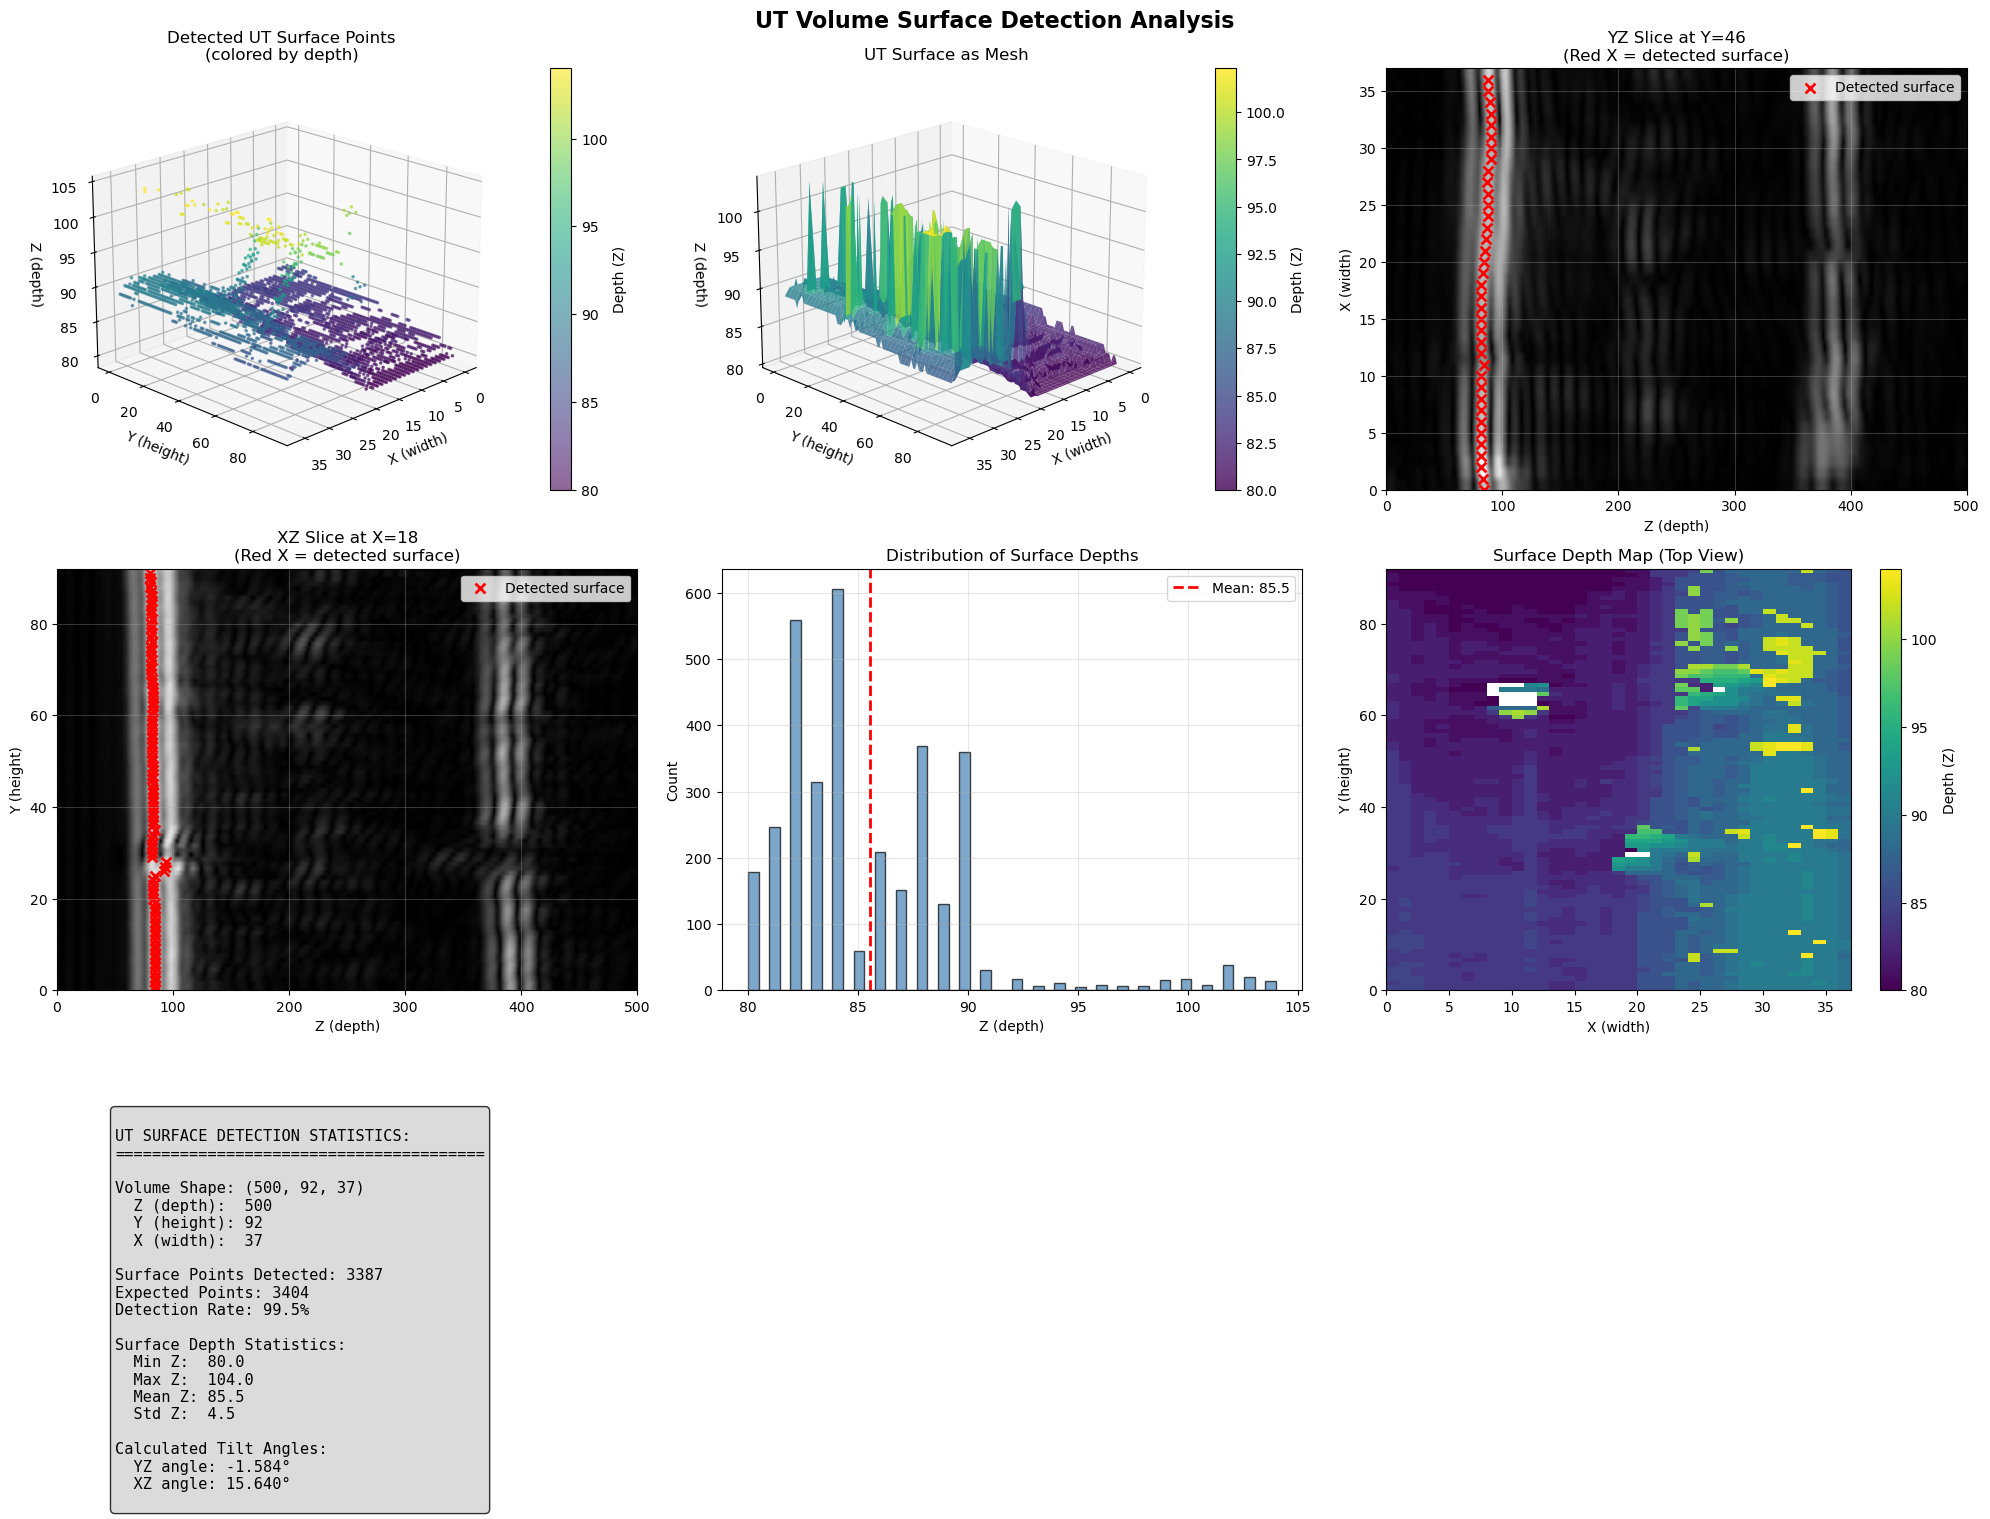

In [8]:
# Visualize UT volume with detected surface points
from mpl_toolkits.mplot3d import Axes3D

# Get surface coordinates (z, y, x)
surface_coords = register.PAUT_surface_coordinates(ut_env, signal_percentage=1.0, min_depth=80, max_depth=None)
print(f"Detected {len(surface_coords)} surface points")

# Create figure with multiple subplots (now 3 rows, 3 columns to add XZ view)
fig = plt.figure(figsize=(20, 16))

# ===== Plot 1: 3D Surface Points =====
ax1 = fig.add_subplot(3, 3, 1, projection='3d')

# Extract coordinates (surface_coords shape: (N, 3), columns: z, y, x)
Z_points = surface_coords[:, 0]  # depth
Y_points = surface_coords[:, 1]  # height
X_points = surface_coords[:, 2]  # width

# Plot the detected surface points (z, y, x)
scatter = ax1.scatter(X_points, Y_points, Z_points, c=Z_points, cmap='viridis',
                      marker='.', s=10, alpha=0.6)
ax1.set_xlabel('X (width)')
ax1.set_ylabel('Y (height)')
ax1.set_zlabel('Z (depth)')
ax1.set_title('Detected UT Surface Points\n(colored by depth)')
plt.colorbar(scatter, ax=ax1, pad=0.1, label='Depth (Z)')
ax1.view_init(elev=20, azim=45)

# ===== Plot 2: Surface as mesh =====
ax2 = fig.add_subplot(3, 3, 2, projection='3d')

# Create a grid for the surface using X and Y, assign Z value to each (y, x)
X_unique = np.unique(X_points)
Y_unique = np.unique(Y_points)
X_grid, Y_grid = np.meshgrid(X_unique, Y_unique)

# Create Z grid from surface points: Z_grid[j, i] with (y, x) order
Z_grid = np.full(X_grid.shape, np.nan)
for j, y in enumerate(Y_unique):
    for i, x in enumerate(X_unique):
        # Find the Z value for this (z, y, x) coordinate
        mask = (surface_coords[:, 1] == y) & (surface_coords[:, 2] == x)
        if np.any(mask):
            Z_grid[j, i] = surface_coords[mask, 0][0]

# Plot the surface (note: axes X=width, Y=height, Z=depth)
surf = ax2.plot_surface(X_grid, Y_grid, Z_grid, cmap='viridis', alpha=0.8,
                        edgecolor='none', antialiased=True)
ax2.set_xlabel('X (width)')
ax2.set_ylabel('Y (height)')
ax2.set_zlabel('Z (depth)')
ax2.set_title('UT Surface as Mesh')
plt.colorbar(surf, ax=ax2, pad=0.1, label='Depth (Z)')
ax2.view_init(elev=20, azim=45)

# ===== Plot 3: Volume slice with surface overlay (YZ) =====
ax3 = fig.add_subplot(3, 3, 3)

# Show a middle slice of the volume along Y axis (YZ view)
mid_y = ut_env.shape[1] // 2
slice_yz = ut_env[:, mid_y, :]  # shape: (Z, X)

ax3.imshow(slice_yz.T, cmap='gray', aspect='auto', origin='lower',
           extent=[0, ut_env.shape[0], 0, ut_env.shape[2]])

# Overlay surface points for this Y slice: select where y == mid_y
y_mask = surface_coords[:, 1] == mid_y
if np.any(y_mask):
    slice_points = surface_coords[y_mask]
    # scatter: x = z (depth), y = x (width), because imshow is transposed
    ax3.scatter(slice_points[:, 0], slice_points[:, 2], c='r', s=50, marker='x', linewidths=2, label='Detected surface')

ax3.set_xlabel('Z (depth)')
ax3.set_ylabel('X (width)')
ax3.set_title(f'YZ Slice at Y={mid_y}\n(Red X = detected surface)')
ax3.legend()
ax3.grid(True, alpha=0.3)

# ===== Plot 4: Volume slice with surface overlay (XZ) =====
ax4 = fig.add_subplot(3, 3, 4)

# Show a middle slice of the volume along X axis (XZ view)
mid_x = ut_env.shape[2] // 2
slice_xz = ut_env[:, :, mid_x]  # shape: (Z, Y)

ax4.imshow(slice_xz.T, cmap='gray', aspect='auto', origin='lower',
           extent=[0, ut_env.shape[0], 0, ut_env.shape[1]])

# Overlay surface points for this X slice: select where x == mid_x
x_mask = surface_coords[:, 2] == mid_x
if np.any(x_mask):
    slice_points_x = surface_coords[x_mask]
    # scatter: x = z (depth), y = y (height), because imshow is transposed
    ax4.scatter(slice_points_x[:, 0], slice_points_x[:, 1], c='r', s=50, marker='x', linewidths=2, label='Detected surface')

ax4.set_xlabel('Z (depth)')
ax4.set_ylabel('Y (height)')
ax4.set_title(f'XZ Slice at X={mid_x}\n(Red X = detected surface)')
ax4.legend()
ax4.grid(True, alpha=0.3)

# ===== Plot 5: Histogram of Z (depth) values =====
ax5 = fig.add_subplot(3, 3, 5)
ax5.hist(Z_points, bins=50, color='steelblue', edgecolor='black', alpha=0.7)
ax5.set_xlabel('Z (depth)')
ax5.set_ylabel('Count')
ax5.set_title('Distribution of Surface Depths')
ax5.grid(True, alpha=0.3)
ax5.axvline(np.mean(Z_points), color='r', linestyle='--', linewidth=2, label=f'Mean: {np.mean(Z_points):.1f}')
ax5.legend()

# ===== Plot 6: Surface depth map (top view, Y vs X, values = Z) =====
ax6 = fig.add_subplot(3, 3, 6)
depth_map = ax6.imshow(Z_grid, cmap='viridis', origin='lower', aspect='auto',
                       extent=[X_unique[0], X_unique[-1] + 1, Y_unique[0], Y_unique[-1] + 1])
ax6.set_xlabel('X (width)')
ax6.set_ylabel('Y (height)')
ax6.set_title('Surface Depth Map (Top View)')
plt.colorbar(depth_map, ax=ax6, label='Depth (Z)')

# ===== Plot 7: Statistics =====
ax7 = fig.add_subplot(3, 3, 7)
ax7.axis('off')

stats_text = f"""
UT SURFACE DETECTION STATISTICS:
{'='*40}

Volume Shape: {ut_env.shape}
  Z (depth):  {ut_env.shape[0]}
  Y (height): {ut_env.shape[1]}
  X (width):  {ut_env.shape[2]}

Surface Points Detected: {len(surface_coords)}
Expected Points: {ut_env.shape[1] * ut_env.shape[2]}
Detection Rate: {100*len(surface_coords)/(ut_env.shape[1]*ut_env.shape[2]):.1f}%

Surface Depth Statistics:
  Min Z:  {np.min(Z_points):.1f}
  Max Z:  {np.max(Z_points):.1f}
  Mean Z: {np.mean(Z_points):.1f}
  Std Z:  {np.std(Z_points):.1f}

Calculated Tilt Angles:
  YZ angle: {angle_yz_ut:.3f}°
  XZ angle: {angle_xz_ut:.3f}°
"""

ax7.text(0.1, 0.9, stats_text, transform=ax7.transAxes, 
        fontsize=11, verticalalignment='top', fontfamily='monospace',
        bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.8))

plt.suptitle('UT Volume Surface Detection Analysis', fontsize=16, weight='bold')
plt.tight_layout()
plt.show()

CALCULATING AND VISUALIZING FITTED PLANE:


Finding surface points: 100%|██████████| 37/37 [00:00<00:00, 1534.57it/s]

Fitted plane equation: Z = 0.2800*X + -0.0277*Y + 81.7402
Plane coefficients:
  a (dZ/dX) = 0.2800
  b (dZ/dY) = -0.0277
  c (offset) = 81.7402

Calculated angles:
  angle_xz = arctan(a) = 15.640°
  angle_yz = arctan(b) = -1.584°

Residuals sum of squares: 36037.071979331165
Mean squared error: 10.6398


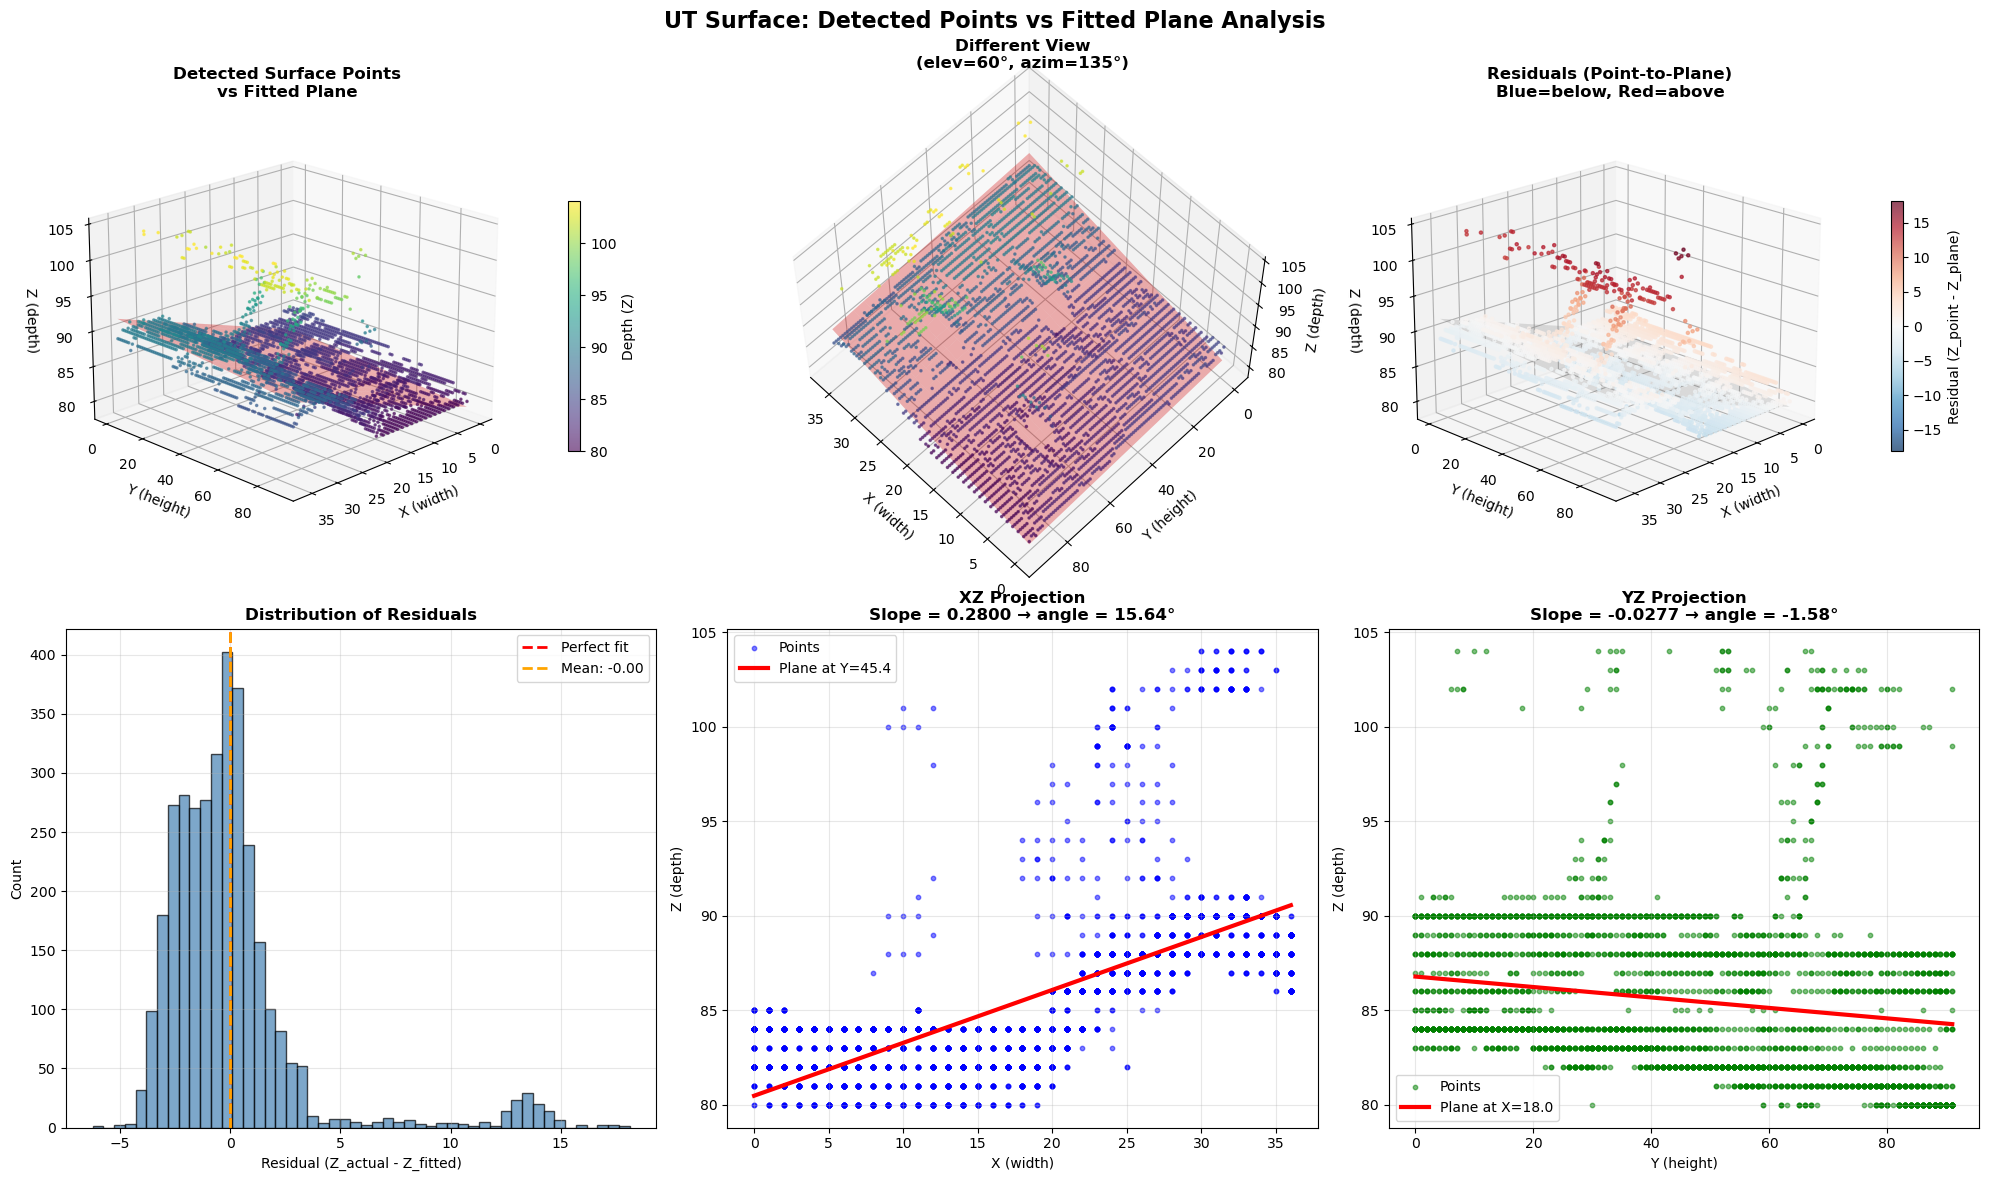


FIT QUALITY METRICS:
Number of points: 3387
RMSE (Root Mean Square Error): 3.2619
Max absolute residual: 18.1192
Std of residuals: 3.2619
R² (coefficient of determination): 0.471327


In [9]:
# Visualize the fitted plane alongside the detected surface points
from mpl_toolkits.mplot3d import Axes3D

print("CALCULATING AND VISUALIZING FITTED PLANE:")
print("="*50)

# Get surface coordinates (using PAUT function which returns z, y, x)
surface_coords = register.PAUT_surface_coordinates(ut_env, min_depth=80, max_depth=None)

# Extract coordinates 
Z_points = surface_coords[:, 0]  # depth
Y_points = surface_coords[:, 1]  # height
X_points = surface_coords[:, 2]  # width

# Fit the plane: Z = a*X + b*Y + c
# This is what YZ_XZ_inclination does internally
A = np.c_[X_points, Y_points, np.ones_like(X_points)]
coeffs, residuals, rank, s = np.linalg.lstsq(A, Z_points, rcond=None)
a, b, c = coeffs

print(f"Fitted plane equation: Z = {a:.4f}*X + {b:.4f}*Y + {c:.4f}")
print(f"Plane coefficients:")
print(f"  a (dZ/dX) = {a:.4f}")
print(f"  b (dZ/dY) = {b:.4f}")
print(f"  c (offset) = {c:.4f}")
print()
print(f"Calculated angles:")
print(f"  angle_xz = arctan(a) = {np.degrees(np.arctan(a)):.3f}°")
print(f"  angle_yz = arctan(b) = {np.degrees(np.arctan(b)):.3f}°")
print()
print(f"Residuals sum of squares: {residuals[0] if len(residuals) > 0 else 'N/A'}")
print(f"Mean squared error: {np.mean((Z_points - (a*X_points + b*Y_points + c))**2):.4f}")
print("="*50)

# Create visualization
fig = plt.figure(figsize=(20, 12))

# ===== Plot 1: 3D view with surface points and fitted plane =====
ax1 = fig.add_subplot(2, 3, 1, projection='3d')

# Plot detected surface points
scatter = ax1.scatter(X_points, Y_points, Z_points, c=Z_points, cmap='viridis',
                     marker='.', s=10, alpha=0.6, label='Detected points')

# Create a mesh grid for the fitted plane
x_range = np.linspace(X_points.min(), X_points.max(), 20)
y_range = np.linspace(Y_points.min(), Y_points.max(), 20)
X_plane, Y_plane = np.meshgrid(x_range, y_range)
Z_plane = a * X_plane + b * Y_plane + c

# Plot the fitted plane
plane_surf = ax1.plot_surface(X_plane, Y_plane, Z_plane, alpha=0.3, color='red',
                              edgecolor='none', label='Fitted plane')

ax1.set_xlabel('X (width)')
ax1.set_ylabel('Y (height)')
ax1.set_zlabel('Z (depth)')
ax1.set_title('Detected Surface Points\nvs Fitted Plane', fontsize=12, weight='bold')
ax1.view_init(elev=20, azim=45)

# Add colorbar for scatter plot
plt.colorbar(scatter, ax=ax1, pad=0.1, label='Depth (Z)', shrink=0.5)

# ===== Plot 2: Different viewing angle =====
ax2 = fig.add_subplot(2, 3, 2, projection='3d')

# Plot detected surface points
ax2.scatter(X_points, Y_points, Z_points, c=Z_points, cmap='viridis',
           marker='.', s=10, alpha=0.6)

# Plot the fitted plane
ax2.plot_surface(X_plane, Y_plane, Z_plane, alpha=0.3, color='red', edgecolor='none')

ax2.set_xlabel('X (width)')
ax2.set_ylabel('Y (height)')
ax2.set_zlabel('Z (depth)')
ax2.set_title('Different View\n(elev=60°, azim=135°)', fontsize=12, weight='bold')
ax2.view_init(elev=60, azim=135)

# ===== Plot 3: Residuals (point-to-plane distances) =====
ax3 = fig.add_subplot(2, 3, 3, projection='3d')

# Calculate residuals (distances from points to plane)
Z_fitted = a * X_points + b * Y_points + c
residuals_vals = Z_points - Z_fitted

# Plot with residuals as color
scatter_res = ax3.scatter(X_points, Y_points, Z_points, c=residuals_vals, 
                         cmap='RdBu_r', marker='.', s=20, alpha=0.7,
                         vmin=-np.abs(residuals_vals).max(),
                         vmax=np.abs(residuals_vals).max())

# Plot the fitted plane
ax3.plot_surface(X_plane, Y_plane, Z_plane, alpha=0.2, color='gray', edgecolor='none')

ax3.set_xlabel('X (width)')
ax3.set_ylabel('Y (height)')
ax3.set_zlabel('Z (depth)')
ax3.set_title('Residuals (Point-to-Plane)\nBlue=below, Red=above', fontsize=12, weight='bold')
ax3.view_init(elev=20, azim=45)
plt.colorbar(scatter_res, ax=ax3, pad=0.1, label='Residual (Z_point - Z_plane)', shrink=0.5)

# ===== Plot 4: Residuals histogram =====
ax4 = fig.add_subplot(2, 3, 4)
ax4.hist(residuals_vals, bins=50, color='steelblue', edgecolor='black', alpha=0.7)
ax4.axvline(0, color='r', linestyle='--', linewidth=2, label='Perfect fit')
ax4.axvline(np.mean(residuals_vals), color='orange', linestyle='--', linewidth=2, 
           label=f'Mean: {np.mean(residuals_vals):.2f}')
ax4.set_xlabel('Residual (Z_actual - Z_fitted)')
ax4.set_ylabel('Count')
ax4.set_title('Distribution of Residuals', fontsize=12, weight='bold')
ax4.legend()
ax4.grid(True, alpha=0.3)

# ===== Plot 5: XZ projection (view from Y direction) =====
ax5 = fig.add_subplot(2, 3, 5)

# Plot points
ax5.scatter(X_points, Z_points, c='blue', s=10, alpha=0.5, label='Points')

# Plot fitted plane projection (at mean Y)
y_mean = Y_points.mean()
x_proj = np.linspace(X_points.min(), X_points.max(), 100)
z_proj = a * x_proj + b * y_mean + c
ax5.plot(x_proj, z_proj, 'r-', linewidth=3, label=f'Plane at Y={y_mean:.1f}')

ax5.set_xlabel('X (width)')
ax5.set_ylabel('Z (depth)')
ax5.set_title(f'XZ Projection\nSlope = {a:.4f} → angle = {np.degrees(np.arctan(a)):.2f}°', 
             fontsize=12, weight='bold')
ax5.legend()
ax5.grid(True, alpha=0.3)

# ===== Plot 6: YZ projection (view from X direction) =====
ax6 = fig.add_subplot(2, 3, 6)

# Plot points
ax6.scatter(Y_points, Z_points, c='green', s=10, alpha=0.5, label='Points')

# Plot fitted plane projection (at mean X)
x_mean = X_points.mean()
y_proj = np.linspace(Y_points.min(), Y_points.max(), 100)
z_proj = a * x_mean + b * y_proj + c
ax6.plot(y_proj, z_proj, 'r-', linewidth=3, label=f'Plane at X={x_mean:.1f}')

ax6.set_xlabel('Y (height)')
ax6.set_ylabel('Z (depth)')
ax6.set_title(f'YZ Projection\nSlope = {b:.4f} → angle = {np.degrees(np.arctan(b)):.2f}°', 
             fontsize=12, weight='bold')
ax6.legend()
ax6.grid(True, alpha=0.3)

plt.suptitle('UT Surface: Detected Points vs Fitted Plane Analysis', fontsize=16, weight='bold')
plt.tight_layout()
plt.show()

# Print quality metrics
print("\nFIT QUALITY METRICS:")
print("="*50)
print(f"Number of points: {len(Z_points)}")
print(f"RMSE (Root Mean Square Error): {np.sqrt(np.mean(residuals_vals**2)):.4f}")
print(f"Max absolute residual: {np.abs(residuals_vals).max():.4f}")
print(f"Std of residuals: {np.std(residuals_vals):.4f}")
print(f"R² (coefficient of determination): {1 - (np.sum(residuals_vals**2) / np.sum((Z_points - Z_points.mean())**2)):.6f}")
print("="*50)


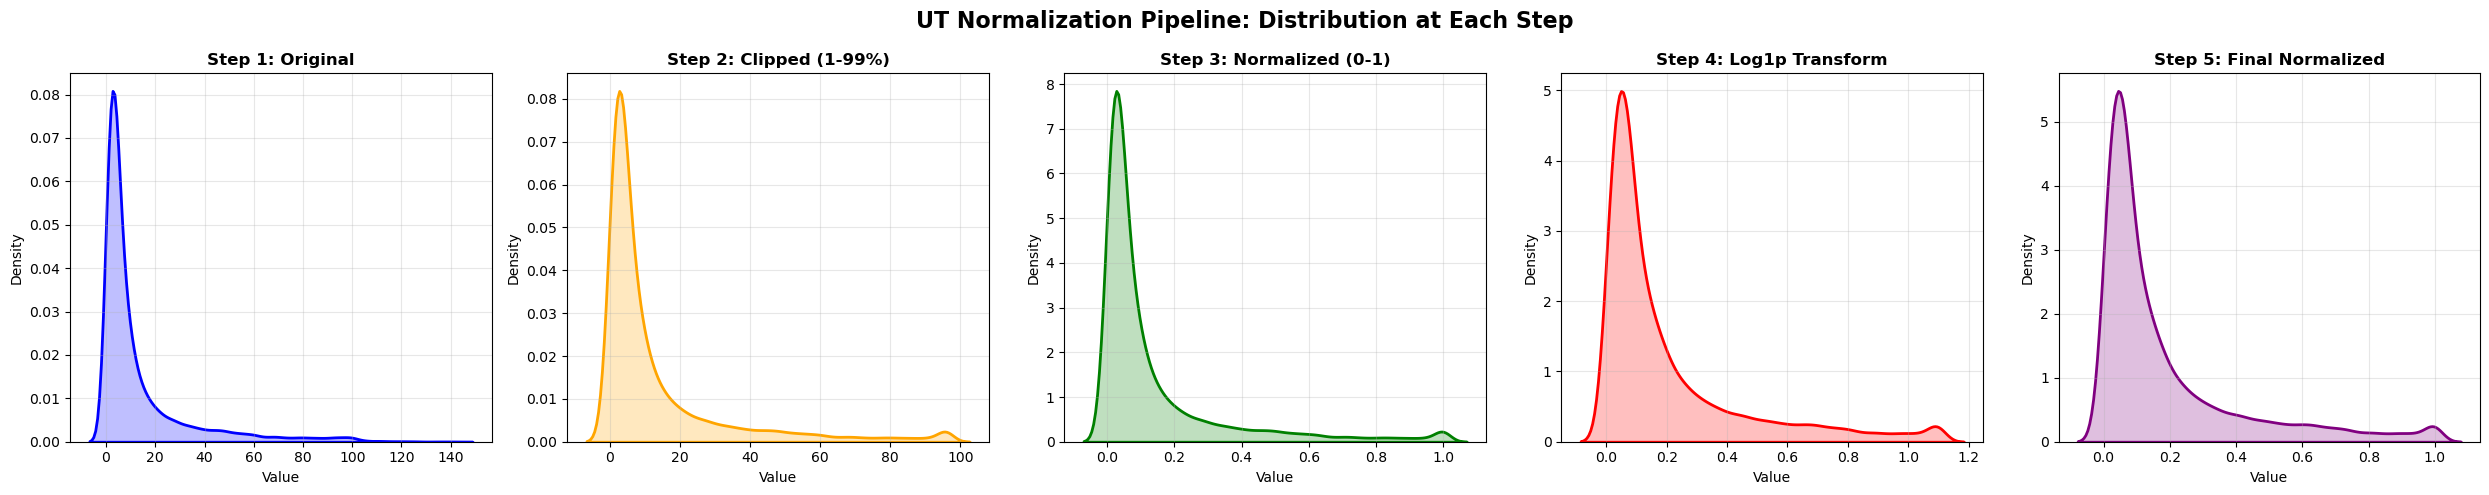

Final normalized array saved to: ut_norm.tif


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [ ]:
# Calculate percentiles, clip and map to 0,1
# Track each transformation step for visualization

# Step 1: Original data (converted to float32)
step1_original = ut_env.astype(np.float32)

# Step 2: Calculate percentiles and clip
lo, hi = np.percentile(step1_original, (1, 99))
step2_clipped = np.clip(step1_original, lo, hi)

# Step 3: Normalize to 0-1 range
step3_normalized = (step2_clipped - lo) / (hi - lo)

# Step 4: Apply log1p transformation
step4_log = np.log1p(2 * step3_normalized)

# Step 5: Final normalization
step5_final = step4_log / (step4_log.max() if step4_log.max() > 0 else 1.0)
ut_norm = step5_final

# Save the final normalized array
tifffile.imwrite('ut_norm.tif', ut_norm.astype(np.float32), imagej=True, metadata={'axes': 'ZYX'})

# ===== VISUALIZATION: KDE PLOTS FOR EACH STEP =====
# Sample data for plotting
sample_size = 50000
flat_indices = np.random.choice(step1_original.size, size=min(sample_size, step1_original.size), replace=False)

# Create figure with 5 KDE subplots
fig, axes = plt.subplots(1, 5, figsize=(25, 5))

# Plot 1: Original data
sns.kdeplot(step1_original.flatten()[flat_indices], ax=axes[0], fill=True, color='blue', linewidth=2)
axes[0].set_title('Step 1: Original', fontsize=12, weight='bold')
axes[0].set_xlabel('Value')
axes[0].set_ylabel('Density')
axes[0].grid(True, alpha=0.3)

# Plot 2: Clipped
sns.kdeplot(step2_clipped.flatten()[flat_indices], ax=axes[1], fill=True, color='orange', linewidth=2)
axes[1].set_title('Step 2: Clipped (1-99%)', fontsize=12, weight='bold')
axes[1].set_xlabel('Value')
axes[1].set_ylabel('Density')
axes[1].grid(True, alpha=0.3)

# Plot 3: Normalized
sns.kdeplot(step3_normalized.flatten()[flat_indices], ax=axes[2], fill=True, color='green', linewidth=2)
axes[2].set_title('Step 3: Normalized (0-1)', fontsize=12, weight='bold')
axes[2].set_xlabel('Value')
axes[2].set_ylabel('Density')
axes[2].grid(True, alpha=0.3)

# Plot 4: Log transform
sns.kdeplot(step4_log.flatten()[flat_indices], ax=axes[3], fill=True, color='red', linewidth=2)
axes[3].set_title('Step 4: Log1p Transform', fontsize=12, weight='bold')
axes[3].set_xlabel('Value')
axes[3].set_ylabel('Density')
axes[3].grid(True, alpha=0.3)

# Plot 5: Final normalized
sns.kdeplot(step5_final.flatten()[flat_indices], ax=axes[4], fill=True, color='purple', linewidth=2)
axes[4].set_title('Step 5: Final Normalized', fontsize=12, weight='bold')
axes[4].set_xlabel('Value')
axes[4].set_ylabel('Density')
axes[4].grid(True, alpha=0.3)

plt.suptitle('UT Normalization Pipeline: Distribution at Each Step', fontsize=16, weight='bold')
plt.tight_layout()
plt.show()
print(f"Final normalized array saved to: ut_norm.tif")




